<a href="https://colab.research.google.com/github/dipayandas97/ML_Notebook_/blob/master/gcForest_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import itertools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

__author__ = "Pierre-Yves Lablanche"
__email__ = "plablanche@aims.ac.za"
__license__ = "MIT"
__version__ = "0.1.6"
#__status__ = "Development"


# noinspection PyUnboundLocalVariable
class gcForest(object):

    def __init__(self, shape_1X=None, n_mgsRFtree=30, window=None, stride=1,
                 cascade_test_size=0.2, n_cascadeRF=2, n_cascadeRFtree=101, cascade_layer=np.inf,
                 min_samples_mgs=0.1, min_samples_cascade=0.05, tolerance=0.0, n_jobs=1):
        """ gcForest Classifier.
        :param shape_1X: int or tuple list or np.array (default=None)
            Shape of a single sample element [n_lines, n_cols]. Required when calling mg_scanning!
            For sequence data a single int can be given.
        :param n_mgsRFtree: int (default=30)
            Number of trees in a Random Forest during Multi Grain Scanning.
        :param window: int (default=None)
            List of window sizes to use during Multi Grain Scanning.
            If 'None' no slicing will be done.
        :param stride: int (default=1)
            Step used when slicing the data.
        :param cascade_test_size: float or int (default=0.2)
            Split fraction or absolute number for cascade training set splitting.
        :param n_cascadeRF: int (default=2)
            Number of Random Forests in a cascade layer.
            For each pseudo Random Forest a complete Random Forest is created, hence
            the total numbe of Random Forests in a layer will be 2*n_cascadeRF.
        :param n_cascadeRFtree: int (default=101)
            Number of trees in a single Random Forest in a cascade layer.
        :param min_samples_mgs: float or int (default=0.1)
            Minimum number of samples in a node to perform a split
            during the training of Multi-Grain Scanning Random Forest.
            If int number_of_samples = int.
            If float, min_samples represents the fraction of the initial n_samples to consider.
        :param min_samples_cascade: float or int (default=0.1)
            Minimum number of samples in a node to perform a split
            during the training of Cascade Random Forest.
            If int number_of_samples = int.
            If float, min_samples represents the fraction of the initial n_samples to consider.
        :param cascade_layer: int (default=np.inf)
            mMximum number of cascade layers allowed.
            Useful to limit the contruction of the cascade.
        :param tolerance: float (default=0.0)
            Accuracy tolerance for the casacade growth.
            If the improvement in accuracy is not better than the tolerance the construction is
            stopped.
        :param n_jobs: int (default=1)
            The number of jobs to run in parallel for any Random Forest fit and predict.
            If -1, then the number of jobs is set to the number of cores.
        """
        setattr(self, 'shape_1X', shape_1X)
        setattr(self, 'n_layer', 0)
        setattr(self, '_n_samples', 0)
        setattr(self, 'n_cascadeRF', int(n_cascadeRF))
        if isinstance(window, int):
            setattr(self, 'window', [window])
        elif isinstance(window, list):
            setattr(self, 'window', window)
        setattr(self, 'stride', stride)
        setattr(self, 'cascade_test_size', cascade_test_size)
        setattr(self, 'n_mgsRFtree', int(n_mgsRFtree))
        setattr(self, 'n_cascadeRFtree', int(n_cascadeRFtree))
        setattr(self, 'cascade_layer', cascade_layer)
        setattr(self, 'min_samples_mgs', min_samples_mgs)
        setattr(self, 'min_samples_cascade', min_samples_cascade)
        setattr(self, 'tolerance', tolerance)
        setattr(self, 'n_jobs', n_jobs)

    def fit(self, X, y):
        """ Training the gcForest on input data X and associated target y.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param y: np.array
            1D array containing the target values.
            Must be of shape [n_samples]
        """
        if np.shape(X)[0] != len(y):
            raise ValueError('Sizes of y and X do not match.')

        mgs_X = self.mg_scanning(X, y)
        _ = self.cascade_forest(mgs_X, y)

    def predict_proba(self, X):
        """ Predict the class probabilities of unknown samples X.
        :param X: np.array
            Array containing the input samples.
            Must be of the same shape [n_samples, data] as the training inputs.
        :return: np.array
            1D array containing the predicted class probabilities for each input sample.
        """
        mgs_X = self.mg_scanning(X)
        cascade_all_pred_prob = self.cascade_forest(mgs_X)
        predict_proba = np.mean(cascade_all_pred_prob, axis=0)

        return predict_proba

    def predict(self, X):
        """ Predict the class of unknown samples X.
        :param X: np.array
            Array containing the input samples.
            Must be of the same shape [n_samples, data] as the training inputs.
        :return: np.array
            1D array containing the predicted class for each input sample.
        """
        pred_proba = self.predict_proba(X=X)
        predictions = np.argmax(pred_proba, axis=1)

        return predictions

    def mg_scanning(self, X, y=None):
        """ Performs a Multi Grain Scanning on input data.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param y: np.array (default=None)
        :return: np.array
            Array of shape [n_samples, .. ] containing Multi Grain Scanning sliced data.
        """
        setattr(self, '_n_samples', np.shape(X)[0])
        shape_1X = getattr(self, 'shape_1X')
        if isinstance(shape_1X, int):
            shape_1X = [1,shape_1X]
        if not getattr(self, 'window'):
            setattr(self, 'window', [shape_1X[1]])

        mgs_pred_prob = []

        for wdw_size in getattr(self, 'window'):
            wdw_pred_prob = self.window_slicing_pred_prob(X, wdw_size, shape_1X, y=y)
            mgs_pred_prob.append(wdw_pred_prob)

        return np.concatenate(mgs_pred_prob, axis=1)

    def window_slicing_pred_prob(self, X, window, shape_1X, y=None):
        """ Performs a window slicing of the input data and send them through Random Forests.
        If target values 'y' are provided sliced data are then used to train the Random Forests.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param window: int
            Size of the window to use for slicing.
        :param shape_1X: list or np.array
            Shape of a single sample.
        :param y: np.array (default=None)
            Target values. If 'None' no training is done.
        :return: np.array
            Array of size [n_samples, ..] containing the Random Forest.
            prediction probability for each input sample.
        """
        n_tree = getattr(self, 'n_mgsRFtree')
        min_samples = getattr(self, 'min_samples_mgs')
        stride = getattr(self, 'stride')

        if shape_1X[0] > 1:
            print('Slicing Images...')
            sliced_X, sliced_y = self._window_slicing_img(X, window, shape_1X, y=y, stride=stride)
        else:
            print('Slicing Sequence...')
            sliced_X, sliced_y = self._window_slicing_sequence(X, window, shape_1X, y=y, stride=stride)

        if y is not None:
            n_jobs = getattr(self, 'n_jobs')
            prf = RandomForestClassifier(n_estimators=n_tree, max_features='sqrt',
                                         min_samples_split=min_samples, oob_score=True, n_jobs=n_jobs)
            crf = RandomForestClassifier(n_estimators=n_tree, max_features=1,
                                         min_samples_split=min_samples, oob_score=True, n_jobs=n_jobs)
            print('Training MGS Random Forests...')
            prf.fit(sliced_X, sliced_y)
            crf.fit(sliced_X, sliced_y)
            setattr(self, '_mgsprf_{}'.format(window), prf)
            setattr(self, '_mgscrf_{}'.format(window), crf)
            pred_prob_prf = prf.oob_decision_function_
            pred_prob_crf = crf.oob_decision_function_

        if hasattr(self, '_mgsprf_{}'.format(window)) and y is None:
            prf = getattr(self, '_mgsprf_{}'.format(window))
            crf = getattr(self, '_mgscrf_{}'.format(window))
            pred_prob_prf = prf.predict_proba(sliced_X)
            pred_prob_crf = crf.predict_proba(sliced_X)

        pred_prob = np.c_[pred_prob_prf, pred_prob_crf]

        return pred_prob.reshape([getattr(self, '_n_samples'), -1])

    def _window_slicing_img(self, X, window, shape_1X, y=None, stride=1):
        """ Slicing procedure for images
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param window: int
            Size of the window to use for slicing.
        :param shape_1X: list or np.array
            Shape of a single sample [n_lines, n_cols].
        :param y: np.array (default=None)
            Target values.
        :param stride: int (default=1)
            Step used when slicing the data.
        :return: np.array and np.array
            Arrays containing the sliced images and target values (empty if 'y' is None).
        """
        if any(s < window for s in shape_1X):
            raise ValueError('window must be smaller than both dimensions for an image')

        len_iter_x = np.floor_divide((shape_1X[1] - window), stride) + 1
        len_iter_y = np.floor_divide((shape_1X[0] - window), stride) + 1
        iterx_array = np.arange(0, stride*len_iter_x, stride)
        itery_array = np.arange(0, stride*len_iter_y, stride)

        ref_row = np.arange(0, window)
        ref_ind = np.ravel([ref_row + shape_1X[1] * i for i in range(window)])
        inds_to_take = [ref_ind + ix + shape_1X[1] * iy
                        for ix, iy in itertools.product(iterx_array, itery_array)]

        sliced_imgs = np.take(X, inds_to_take, axis=1).reshape(-1, window**2)

        if y is not None:
            sliced_target = np.repeat(y, len_iter_x * len_iter_y)
        elif y is None:
            sliced_target = None

        return sliced_imgs, sliced_target

    def _window_slicing_sequence(self, X, window, shape_1X, y=None, stride=1):
        """ Slicing procedure for sequences (aka shape_1X = [.., 1]).
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param window: int
            Size of the window to use for slicing.
        :param shape_1X: list or np.array
            Shape of a single sample [n_lines, n_col].
        :param y: np.array (default=None)
            Target values.
        :param stride: int (default=1)
            Step used when slicing the data.
        :return: np.array and np.array
            Arrays containing the sliced sequences and target values (empty if 'y' is None).
        """
        if shape_1X[1] < window:
            raise ValueError('window must be smaller than the sequence dimension')

        len_iter = np.floor_divide((shape_1X[1] - window), stride) + 1
        iter_array = np.arange(0, stride*len_iter, stride)

        ind_1X = np.arange(np.prod(shape_1X))
        inds_to_take = [ind_1X[i:i+window] for i in iter_array]
        sliced_sqce = np.take(X, inds_to_take, axis=1).reshape(-1, window)

        if y is not None:
            sliced_target = np.repeat(y, len_iter)
        elif y is None:
            sliced_target = None

        return sliced_sqce, sliced_target

    def cascade_forest(self, X, y=None):
        """ Perform (or train if 'y' is not None) a cascade forest estimator.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param y: np.array (default=None)
            Target values. If 'None' perform training.
        :return: np.array
            1D array containing the predicted class for each input sample.
        """
        if y is not None:
            setattr(self, 'n_layer', 0)
            test_size = getattr(self, 'cascade_test_size')
            max_layers = getattr(self, 'cascade_layer')
            tol = getattr(self, 'tolerance')

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            self.n_layer += 1
            prf_crf_pred_ref = self._cascade_layer(X_train, y_train)
            accuracy_ref = self._cascade_evaluation(X_test, y_test)
            feat_arr = self._create_feat_arr(X_train, prf_crf_pred_ref)

            self.n_layer += 1
            prf_crf_pred_layer = self._cascade_layer(feat_arr, y_train)
            accuracy_layer = self._cascade_evaluation(X_test, y_test)

            while accuracy_layer > (accuracy_ref + tol) and self.n_layer <= max_layers:
                accuracy_ref = accuracy_layer
                prf_crf_pred_ref = prf_crf_pred_layer
                feat_arr = self._create_feat_arr(X_train, prf_crf_pred_ref)
                self.n_layer += 1
                prf_crf_pred_layer = self._cascade_layer(feat_arr, y_train)
                accuracy_layer = self._cascade_evaluation(X_test, y_test)

            if accuracy_layer < accuracy_ref :
                n_cascadeRF = getattr(self, 'n_cascadeRF')
                for irf in range(n_cascadeRF):
                    delattr(self, '_casprf{}_{}'.format(self.n_layer, irf))
                    delattr(self, '_cascrf{}_{}'.format(self.n_layer, irf))
                self.n_layer -= 1

        elif y is None:
            at_layer = 1
            prf_crf_pred_ref = self._cascade_layer(X, layer=at_layer)
            while at_layer < getattr(self, 'n_layer'):
                at_layer += 1
                feat_arr = self._create_feat_arr(X, prf_crf_pred_ref)
                prf_crf_pred_ref = self._cascade_layer(feat_arr, layer=at_layer)

        return prf_crf_pred_ref

    def _cascade_layer(self, X, y=None, layer=0):
        """ Cascade layer containing Random Forest estimators.
        If y is not None the layer is trained.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param y: np.array (default=None)
            Target values. If 'None' perform training.
        :param layer: int (default=0)
            Layer indice. Used to call the previously trained layer.
        :return: list
            List containing the prediction probabilities for all samples.
        """
        n_tree = getattr(self, 'n_cascadeRFtree')
        n_cascadeRF = getattr(self, 'n_cascadeRF')
        min_samples = getattr(self, 'min_samples_cascade')

        n_jobs = getattr(self, 'n_jobs')
        prf = RandomForestClassifier(n_estimators=n_tree, max_features='sqrt',
                                     min_samples_split=min_samples, oob_score=True, n_jobs=n_jobs)
        crf = RandomForestClassifier(n_estimators=n_tree, max_features=1,
                                     min_samples_split=min_samples, oob_score=True, n_jobs=n_jobs)

        prf_crf_pred = []
        if y is not None:
            print('Adding/Training Layer, n_layer={}'.format(self.n_layer))
            for irf in range(n_cascadeRF):
                prf.fit(X, y)
                crf.fit(X, y)
                setattr(self, '_casprf{}_{}'.format(self.n_layer, irf), prf)
                setattr(self, '_cascrf{}_{}'.format(self.n_layer, irf), crf)
                prf_crf_pred.append(prf.oob_decision_function_)
                prf_crf_pred.append(crf.oob_decision_function_)
        elif y is None:
            for irf in range(n_cascadeRF):
                prf = getattr(self, '_casprf{}_{}'.format(layer, irf))
                crf = getattr(self, '_cascrf{}_{}'.format(layer, irf))
                prf_crf_pred.append(prf.predict_proba(X))
                prf_crf_pred.append(crf.predict_proba(X))

        return prf_crf_pred

    def _cascade_evaluation(self, X_test, y_test):
        """ Evaluate the accuracy of the cascade using X and y.
        :param X_test: np.array
            Array containing the test input samples.
            Must be of the same shape as training data.
        :param y_test: np.array
            Test target values.
        :return: float
            the cascade accuracy.
        """
        casc_pred_prob = np.mean(self.cascade_forest(X_test), axis=0)
        casc_pred = np.argmax(casc_pred_prob, axis=1)
        casc_accuracy = accuracy_score(y_true=y_test, y_pred=casc_pred)
        print('Layer validation accuracy = {}'.format(casc_accuracy))

        return casc_accuracy

    def _create_feat_arr(self, X, prf_crf_pred):
        """ Concatenate the original feature vector with the predicition probabilities
        of a cascade layer.
        :param X: np.array
            Array containing the input samples.
            Must be of shape [n_samples, data] where data is a 1D array.
        :param prf_crf_pred: list
            Prediction probabilities by a cascade layer for X.
        :return: np.array
            Concatenation of X and the predicted probabilities.
            To be used for the next layer in a cascade forest.
        """
        swap_pred = np.swapaxes(prf_crf_pred, 0, 1)
        add_feat = swap_pred.reshape([np.shape(X)[0], -1])
        feat_arr = np.concatenate([add_feat, X], axis=1)

        return feat_arr

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = datasets.load_iris()

In [0]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

In [36]:
X.shape

(150, 2)

In [37]:
y.shape

(150,)

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33)

In [39]:
gcf = gcForest(shape_1X=2, window=2, tolerance=0.0)
gcf.fit(X_tr, y_tr)

Slicing Sequence...
Training MGS Random Forests...
Adding/Training Layer, n_layer=1
Layer validation accuracy = 0.7
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.65


In [40]:
pred_X = gcf.predict(X_te)
# evaluating accuracy
accuracy = accuracy_score(y_true=y_te, y_pred=pred_X)
print('gcForest accuracy : {}'.format(accuracy))

Slicing Sequence...
gcForest accuracy : 0.64


In [0]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [0]:
# loading the data
digits = load_digits()
X = digits.data
y = digits.target
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.4)

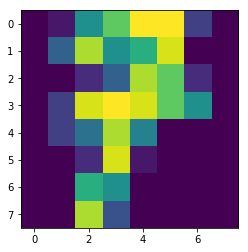

(64,)

In [59]:
plt.imshow(X_tr[0].reshape(8,8))
plt.show()
X_tr[0].shape

In [60]:
gcf = gcForest(shape_1X=[8,8], window=[2,4,6], tolerance=0.0, min_samples_mgs=10, min_samples_cascade=7)
gcf.fit(X_tr, y_tr)

Slicing Images...
Training MGS Random Forests...
Slicing Images...
Training MGS Random Forests...
Slicing Images...
Training MGS Random Forests...
Adding/Training Layer, n_layer=1
Layer validation accuracy = 0.9722222222222222
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.9722222222222222


In [61]:
pred_X = gcf.predict(X_te)
accuracy = accuracy_score(y_true=y_te, y_pred=pred_X)
print('gcForest accuracy : {}'.format(accuracy))

Slicing Images...
Slicing Images...
Slicing Images...
gcForest accuracy : 0.9777468706536857
